<a href="https://colab.research.google.com/github/edypidy/SkyElephant-not-a-FlyingElephant/blob/main/CustomModel/DataScience_Project2_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Load Data & Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

PATH = os.path.join(os.getcwd(), '/drive/MyDrive/DataScience_Midterm_Project')
sys.path.append(PATH)

Mounted at /content/drive


In [ ]:
!pip install einops

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import repeat

import einops
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 388 kB/s 


In [ ]:
print("VERSION CHECK".center(50).replace(' ', '='))
print(f"python == {sys.version}".ljust(30))
print()

print(f"torch == {torch.__version__}".ljust(30))
print(f"einops == {einops.__version__}".ljust(30))
print(f"numpy == {np.__version__}".ljust(30))
print(f"pandas == {pd.__version__}".ljust(30))
print(f"sklearn == {sklearn.__version__}".ljust(30))
print()
print("".center(50).replace(' ', '='))

==================VERSION=CHECK===================
python == 3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]

torch == 1.12.1+cu113         
einops == 0.6.0               
numpy == 1.21.6               
pandas == 1.3.5               
sklearn == 1.0.2              



In [ ]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1004)

## 0-1. FTTransformer

In [ ]:
# numerical embedder

class NumericalEmbedder(nn.Module):
    def __init__(self, dim, num_numerical_types):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_numerical_types, dim))
        self.biases = nn.Parameter(torch.randn(num_numerical_types, dim))

    def forward(self, x):
        x = x.unsqueeze(-1)
        return x * self.weights + self.biases


# Feedforward

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_mult = 4, dropout = 0.):
        super().__init__()
        self.Layer1 = nn.Sequential(nn.LayerNorm(in_dim),
                                    nn.Linear(in_dim, in_dim*hidden_mult*2),
                                    GEGLU(),
                                    nn.Dropout(dropout))
        self.Layer2 = nn.Linear(in_dim*hidden_mult, in_dim)
        self.norm = nn.LayerNorm(in_dim)
    
    def forward(self, x):
        output = self.Layer1(x)
        output = self.Layer2(output)
        output = self.norm(output)
        output = output + x # residual
        return output


# Self Attention

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        output = self.attn(x,x,x)[0]
        output = self.norm(output)
        output = output + x # residual
        return output


# Transformer

class Transformer(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, attn_dropout, ff_dropout):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                SelfAttention(embed_dim, num_heads=num_heads, dropout=attn_dropout),
                FeedForward(embed_dim, dropout=ff_dropout),
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        return x

In [ ]:
class FTTransformer(nn.Module):
    def __init__(self, *,
        categories,
        num_continuous,
        embed_dim = 16,
        depth = 2,
        heads = 8,
        dim_out = 1,
        num_special_tokens = 2,
        attn_dropout = 0.,
        ff_dropout = 0.):
        
        super().__init__()

        # Treat Categories

        self.num_categories = len(categories)
        self.num_unique_categories = sum(categories)

        # Create category embeddings table

        self.num_special_tokens = num_special_tokens # Since add categories_offset to x_categories, first 'num_special_tokens' special tokens mean NA
        total_tokens = self.num_unique_categories + num_special_tokens
        # embedding table
        self.categorical_embeds = nn.Embedding(total_tokens, embed_dim) # LookUp Table : total_tokens x embed_dim

        # offset of categories for the categories embedding table like positional encoding (Alternative methodology from paper)
        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value = num_special_tokens)
        categories_offset = categories_offset.cumsum(dim = -1)[:-1] # by cumsuming so every category is distinguished
        self.register_buffer('categories_offset', categories_offset) # categories offset must be unlearnable


        # Treat Continuous

        self.numerical_embedder = NumericalEmbedder(embed_dim, num_continuous)


        # cls token

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))


        # Transformer

        self.transformer = Transformer(embed_dim=embed_dim,
                                       depth=depth,
                                       num_heads=heads,
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout,
                                       )


        # To logits

        self.to_logits = nn.Sequential(nn.LayerNorm(embed_dim),
                                       nn.ReLU(),
                                       nn.Linear(embed_dim, dim_out)
                                       )




    def forward(self, x_categ, x_numer):
        b = x_categ.shape[0] # batch size

        assert x_categ.shape[-1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'
        x_categ += self.categories_offset

        x_categ = self.categorical_embeds(x_categ) # Categories Embedding is 'LookUp Table' method => batch x categ_col_nums x embed_dim

        # add numerically embedded tokens

        x_numer = self.numerical_embedder(x_numer)

        # concat categorical and numerical

        x = torch.cat((x_categ, x_numer), dim = 1)

        # Append cls tokens by batch == torch.cat([self.cls_token for _ in range(b)], dim=0)

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim = 1)

        # Tabular transformer

        x = self.transformer(x)

        # get cls token

        x = x[:, 0]

        return self.to_logits(x)

## 0-2. Bicon FTTransformer

In [ ]:
# numerical embedder

class NumericalEmbedder(nn.Module):
    def __init__(self, dim, num_numerical_types):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_numerical_types, dim))
        self.biases = nn.Parameter(torch.randn(num_numerical_types, dim))

    def forward(self, x):
        x = x.unsqueeze(-1)
        return x * self.weights + self.biases


# Feedforward

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_mult = 4, dropout = 0.):
        super().__init__()
        self.Layer1 = nn.Sequential(nn.LayerNorm(in_dim),
                                    nn.Linear(in_dim, in_dim*hidden_mult*2),
                                    GEGLU(),
                                    nn.Dropout(dropout))
        self.Layer2 = nn.Linear(in_dim*hidden_mult, in_dim)
        self.norm = nn.LayerNorm(in_dim)
    
    def forward(self, x):
        output = self.Layer1(x)
        output = self.Layer2(output)
        output = self.norm(output)
        output = output + x # residual
        return output


# Attention for Binary Conditions

class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, x, k, v):
        output, attn_weights = self.attn(x,k,v)
        output = self.norm(output)
        output = output + x # residual
        return output, attn_weights


# Self Attention

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        output = self.attn(x,x,x)[0]
        output = self.norm(output)
        output = output + x # residual
        return output


# Transformer

class Transformer(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, attn_dropout, ff_dropout):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                SelfAttention(embed_dim, num_heads=num_heads, dropout=attn_dropout),
                FeedForward(embed_dim, dropout=ff_dropout),
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        return x

In [ ]:
class BiconFTTransformer(nn.Module):
    def __init__(self, *,
        categories,
        num_continuous,
        num_bicons, # Number of Binary Conditions (Input)
        embed_dim = 16,
        depth = 2,
        heads = 8,
        dim_out = 1,
        num_special_tokens = 2,
        attn_dropout = 0.,
        ff_dropout = 0.):
        
        super().__init__()

        # Treat Categories

        self.num_categories = len(categories)
        self.num_unique_categories = sum(categories)

        # Create category embeddings table

        self.num_special_tokens = num_special_tokens # Since add categories_offset to x_categories, first 'num_special_tokens' special tokens mean NA
        total_tokens = self.num_unique_categories + num_special_tokens
        # embedding table
        self.categorical_embeds = nn.Embedding(total_tokens, embed_dim) # LookUp Table : total_tokens x embed_dim

        # offset of categories for the categories embedding table like positional encoding (Alternative methodology from paper)
        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value = num_special_tokens)
        categories_offset = categories_offset.cumsum(dim = -1)[:-1] # by cumsuming so every category is distinguished
        self.register_buffer('categories_offset', categories_offset) # categories offset must be unlearnable


        # Treat Continuous

        self.numerical_embedder = NumericalEmbedder(embed_dim, num_continuous)
        

        # Treat Binary Condition

        self.bicon_embeds = nn.Embedding(2*num_bicons, embed_dim)
        bicon_offset = torch.arange(0,2*num_bicons,2) # every Binary Condition is distinguished
        self.register_buffer('bicon_offset', bicon_offset) # bicon offset must be unlearnable


        # cls token

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))


        # Attention for Bicon

        self.attention = Attention(embed_dim=embed_dim,
                                   num_heads=1, # 8
                                   dropout=attn_dropout)


        # Transformer

        self.transformer = Transformer(embed_dim=embed_dim,
                                       depth=depth,
                                       num_heads=heads,
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout,
                                       )


        # To logits

        self.to_logits = nn.Sequential(nn.LayerNorm(embed_dim),
                                       nn.ReLU(),
                                       nn.Linear(embed_dim, dim_out)
                                       )




    def forward(self, x_categ, x_numer, x_bicon):
        b = x_categ.shape[0] # batch size

        assert x_categ.shape[-1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'
        x_categ += self.categories_offset

        x_categ = self.categorical_embeds(x_categ) # Categories Embedding is 'LookUp Table' method => batch x categ_col_nums x embed_dim

        # add numerically embedded tokens

        x_numer = self.numerical_embedder(x_numer)

        # concat categorical and numerical

        x = torch.cat((x_categ, x_numer), dim = 1)

        # bicon

        x_bicon += self.bicon_offset
        x_bicon = self.bicon_embeds(x_bicon)
        x, attn_weights = self.attention(x, x_bicon, x_bicon)

        # Append cls tokens by batch == torch.cat([self.cls_token for _ in range(b)], dim=0)

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim = 1)

        # Tabular transformer

        x = self.transformer(x)

        # get cls token

        x = x[:, 0]

        # Augmetation

        if self.training:
            x = x*(1+0.005*torch.randn_like(x, requires_grad=False))

        return self.to_logits(x), attn_weights

# 1. HeartDisease_FTTransformer_Experiment

## 1-1. DATASET

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, labels=None, cat_features=None, num_features=None):
        self.cat_df = df[cat_features]
        self.num_df = df[num_features]
        self.labels = labels


    def __getitem__(self, index):
                
        if self.labels is not None:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            label = torch.Tensor(self.labels.iloc[index])
            return x_categ, x_numer, label
        else:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            return x_categ, x_numer
        
    def __len__(self):
        return len(self.cat_df)

## 1-2. TRAIN VALID FUNCTION

In [ ]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, cfg):
    model.to(device)
    criterion = cfg['CRITERION']
    
    best_score = 0
    best_model = None
    
    train_losses = []
    val_losses = []

    for epoch in range(1, cfg['EPOCHS']+1):
        model.train()
        train_loss = []
        for x_categ, x_numer, label in tqdm(iter(train_loader)):

            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(x_categ, x_numer)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device, cfg['VALIDATION_CFG'])
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_losses.append(np.mean(train_loss))
        val_losses.append(val_loss)


        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
    
    return best_model, train_losses, val_losses

In [ ]:
def validation(model, criterion, val_loader, device, cfg):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = cfg['THRESHOLD']
    with torch.no_grad():
        for x_categ, x_numer, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(x_categ, x_numer)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    # pred_labels = np.array(pred_labels)
    val_score = cfg['SCORE'](y_true=true_labels, y_pred=pred_labels)
    return np.mean(val_loss), val_score

In [ ]:
def inference(model, test_loader, device, cfg):
    model.to(device)
    model.eval()
    preds = []
    threshold = cfg['THRESHOLD']
    
    with torch.no_grad():
        for x_categ, x_numer in tqdm(iter(test_loader)):
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)

            model_pred = model(x_categ, x_numer)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    # preds = np.array(preds)
    
    return preds

## 1-3. CHECK MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    # 'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        'SCORE' : metrics.accuracy_score
        # 'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
def class_mapping(df, feature):
    class_map = {cls:val for val,cls in enumerate(df[feature].unique())}
    print(f'{feature} => {class_map}')
    return df[feature].map(class_map), class_map


train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
target = ['HeartDisease', 'Cholesterol']


categories = []
for feature in cat_features:
    train_df[feature], class_map = class_mapping(train_df, feature)
    test_df[feature] = test_df[feature].map(class_map)

    # categories class num
    categories.append(len(class_map))
categories = tuple(categories)


train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                  train_df[[target[0]]], # target[0] : HeartDisease 
                                                                  test_size=100, 
                                                                  )
test_df = test_df[num_features + cat_features]

Sex => {'M': 0, 'F': 1}
FastingBS => {0: 0, 1: 1}
ExerciseAngina => {'N': 0, 'Y': 1}
ChestPainType => {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
RestingECG => {'Normal': 0, 'ST': 1, 'LVH': 2}
ST_Slope => {'Up': 0, 'Flat': 1, 'Down': 2}


In [ ]:
sc_df = StandardScaler()

sc_df.fit(train_df[num_features])

train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

In [ ]:
train_dataset = CustomDataset(train_df, train_labels, cat_features=cat_features, num_features=num_features)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_dataset = CustomDataset(valid_df, valid_labels, cat_features=cat_features, num_features=num_features)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_df, None, cat_features=cat_features, num_features=num_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
model = FTTransformer(categories = categories,
                           num_continuous = len(num_features),
                           embed_dim = 8,
                           depth = 1,
                           heads = 2,
                           dim_out = 1,
                           num_special_tokens = 2,
                           attn_dropout = 0.,
                           ff_dropout = 0.,
                          )          

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.55122] Val Loss : [0.49850] Val Score : [0.84000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.43830] Val Loss : [0.48291] Val Score : [0.82000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.36719] Val Loss : [0.45331] Val Score : [0.84000]
Epoch 00003: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.33454] Val Loss : [0.41280] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.32127] Val Loss : [0.37138] Val Score : [0.87000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.32285] Val Loss : [0.35842] Val Score : [0.87000]
Epoch 00006: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.30429] Val Loss : [0.36047] Val Score : [0.87000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.30650] Val Loss : [0.35841] Val Score : [0.88000]
Epoch 00008: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.29622] Val Loss : [0.33817] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.29342] Val Loss : [0.33666] Val Score : [0.88000]
Epoch 00010: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.29305] Val Loss : [0.33904] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.29010] Val Loss : [0.33453] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.28966] Val Loss : [0.33563] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.28804] Val Loss : [0.33185] Val Score : [0.89000]
Epoch 00014: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.28638] Val Loss : [0.33214] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.28512] Val Loss : [0.33274] Val Score : [0.89000]
Epoch 00016: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.28445] Val Loss : [0.33113] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.28376] Val Loss : [0.33107] Val Score : [0.89000]
Epoch 00018: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.28300] Val Loss : [0.33342] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.28429] Val Loss : [0.33176] Val Score : [0.89000]
Epoch 00020: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.28280] Val Loss : [0.33122] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.28300] Val Loss : [0.33116] Val Score : [0.89000]
Epoch 00022: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.28294] Val Loss : [0.33141] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.28267] Val Loss : [0.33143] Val Score : [0.89000]
Epoch 00024: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.28228] Val Loss : [0.33136] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.28318] Val Loss : [0.33145] Val Score : [0.89000]
Epoch 00026: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.28248] Val Loss : [0.33136] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.28321] Val Loss : [0.33135] Val Score : [0.89000]
Epoch 00028: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.28235] Val Loss : [0.33133] Val Score : [0.89000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.28280] Val Loss : [0.33134] Val Score : [0.89000]
Epoch 00030: reducing learning rate of group 0 to 6.1035e-07.


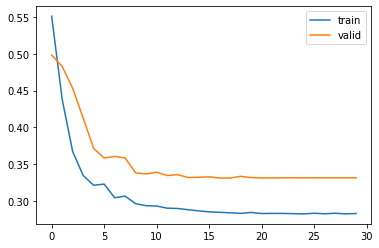

In [ ]:
infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
plt.legend()
plt.show()

In [ ]:
preds = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])

test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
test_label = test_label[target[0]] # target[0] : HeartDisease 

TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)

  0%|          | 0/7 [00:00<?, ?it/s]

0.73

## 1-4. EXPERIMENT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    # 'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        'SCORE' : metrics.accuracy_score
        # 'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
test_scores = []
EXPERIMENT_NUM = 30

for _ in range(EXPERIMENT_NUM):
    # Load df
    train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


    num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
    cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
    target = ['HeartDisease', 'Cholesterol']

    # Label Encoding
    categories = []
    for feature in cat_features:
        train_df[feature], class_map = class_mapping(train_df, feature)
        test_df[feature] = test_df[feature].map(class_map)

        # categories class num
        categories.append(len(class_map))
    categories = tuple(categories)


    # train_valid split
    train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                    train_df[[target[0]]], # target[0] : HeartDisease 
                                                                    test_size=100, 
                                                                    )
    test_df = test_df[num_features + cat_features]


    # Standard Scaling
    sc_df = StandardScaler()

    sc_df.fit(train_df[num_features])

    train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
    valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
    test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])


    # DataSet
    train_dataset = CustomDataset(train_df, train_labels, cat_features=cat_features, num_features=num_features)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

    valid_dataset = CustomDataset(valid_df, valid_labels, cat_features=cat_features, num_features=num_features)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_df, None, cat_features=cat_features, num_features=num_features)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


    # model, optimizer, scheduler
    model = FTTransformer(categories = categories,
                            num_continuous = len(num_features),
                            embed_dim = 8,
                            depth = 1,
                            heads = 2,
                            dim_out = 1,
                            num_special_tokens = 2,
                            attn_dropout = 0.,
                            ff_dropout = 0.,
                            )          

    model.eval()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])


    # Infer model
    infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

    plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
    plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
    plt.legend()
    plt.show()


    # Test Scoring
    preds = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])

    test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
    test_label = test_label[target[0]] # target[0] : HeartDisease 

    test_score = TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)
    test_scores.append([test_score])

In [ ]:
test_scores = np.array(test_scores)
np.mean(test_scores), np.std(test_scores)

# 2. HeartDisease_BiconFTTransformer_Attention_Plot_Experiment

## 2-1. DATASET

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, labels=None, bicons=None, cat_features=None, num_features=None):
        self.cat_df = df[cat_features]
        self.num_df = df[num_features]
        self.labels = labels
        
        bicon_df = []
        for bicon in bicons:
            bicon_df.append(df.apply(bicon, axis=1))
        self.bicon_df = pd.concat(bicon_df, axis=1)


    def __getitem__(self, index):
                
        if self.labels is not None:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            x_bicon = torch.Tensor(self.bicon_df.iloc[index])
            label = torch.Tensor(self.labels.iloc[index])
            return x_categ, x_numer, x_bicon, label
        else:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            x_bicon = torch.Tensor(self.bicon_df.iloc[index])
            return x_categ, x_numer, x_bicon
        
    def __len__(self):
        return len(self.cat_df)

## 2-2. TRAIN VALID FUNCTION

In [ ]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, cfg):
    model.to(device)
    criterion = cfg['CRITERION']
    
    best_score = 0
    best_model = None
    
    train_losses = []
    val_losses = []

    for epoch in range(1, cfg['EPOCHS']+1):
        model.train()
        train_loss = []
        for x_categ, x_numer, x_bicon, label in tqdm(iter(train_loader)):

            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred, _ = model(x_categ, x_numer, x_bicon)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device, cfg['VALIDATION_CFG'])
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_losses.append(np.mean(train_loss))
        val_losses.append(val_loss)


        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score < val_score:
            best_score = val_score
            best_model = model
    
    return best_model, train_losses, val_losses

In [ ]:
def validation(model, criterion, val_loader, device, cfg):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = cfg['THRESHOLD']
    with torch.no_grad():
        for x_categ, x_numer, x_bicon, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)
            label = label.float().to(device)
            
            model_pred, _ = model(x_categ, x_numer, x_bicon)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    # pred_labels = np.array(pred_labels)
    val_score = cfg['SCORE'](y_true=true_labels, y_pred=pred_labels)
    return np.mean(val_loss), val_score

In [ ]:
def inference(model, test_loader, device, cfg):
    model.to(device)
    model.eval()
    preds = []
    attn_weights_list = []
    threshold = cfg['THRESHOLD']
    
    with torch.no_grad():
        for x_categ, x_numer, x_bicon in tqdm(iter(test_loader)):
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)

            model_pred, attn_weights = model(x_categ, x_numer, x_bicon)
            attn_weights_list.append(attn_weights)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    preds = np.where(np.array(preds) > threshold, 1, 0)
    # preds = np.array(preds)
    
    return preds, attn_weights_list

## 2-3. CHECK MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    # 'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        'SCORE' : metrics.accuracy_score
        # 'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
def class_mapping(df, feature):
    class_map = {cls:val for val,cls in enumerate(df[feature].unique())}
    print(f'{feature} => {class_map}')
    return df[feature].map(class_map), class_map


train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
target = ['HeartDisease', 'Cholesterol']


categories = []
for feature in cat_features:
    train_df[feature], class_map = class_mapping(train_df, feature)
    test_df[feature] = test_df[feature].map(class_map)

    # categories class num
    categories.append(len(class_map))
categories = tuple(categories)


train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                  train_df[[target[0]]], # target[0] : HeartDisease 
                                                                  test_size=100, 
                                                                  )
test_df = test_df[num_features + cat_features]

Sex => {'M': 0, 'F': 1}
FastingBS => {0: 0, 1: 1}
ExerciseAngina => {'N': 0, 'Y': 1}
ChestPainType => {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
RestingECG => {'Normal': 0, 'ST': 1, 'LVH': 2}
ST_Slope => {'Up': 0, 'Flat': 1, 'Down': 2}


In [ ]:
sc_df = StandardScaler()

sc_df.fit(train_df[num_features])

train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

In [ ]:
bicons_string = '''
bicons = [
 
lambda x: x['ExerciseAngina'] == 1,
lambda x: x['Oldpeak'] != 0,
lambda x: x['ChestPainType'] == 2,
lambda x: (x['ExerciseAngina'] == 1) and (x['Oldpeak'] != 0),
lambda x: (x['ExerciseAngina'] == 1) and (x['ChestPainType'] == 2),
lambda x: (x['Oldpeak'] != 0) and (x['ChestPainType'] == 2),
lambda x: (x['ExerciseAngina'] == 1) and (x['Oldpeak'] != 0) and (x['ChestPainType'] == 2),
]
'''
exec(bicons_string)
bicons = bicons

In [ ]:
train_dataset = CustomDataset(train_df, train_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_dataset = CustomDataset(valid_df, valid_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_df, None, bicons=bicons, cat_features=cat_features, num_features=num_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
model = BiconFTTransformer(categories = categories,
                           num_continuous = len(num_features),
                           num_bicons = len(bicons), # Number of Binary Conditions (Input)
                           embed_dim = 8,
                           depth = 1,
                           heads = 2,
                           dim_out = 1,
                           num_special_tokens = 2,
                           attn_dropout = 0.,
                           ff_dropout = 0.,
                          )          

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.57013] Val Loss : [0.44120] Val Score : [0.83000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.49613] Val Loss : [0.34128] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.43906] Val Loss : [0.27511] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.39364] Val Loss : [0.25733] Val Score : [0.90000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.39954] Val Loss : [0.25609] Val Score : [0.91000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.38977] Val Loss : [0.22408] Val Score : [0.91000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.37438] Val Loss : [0.22592] Val Score : [0.91000]
Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.36120] Val Loss : [0.22288] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.35445] Val Loss : [0.25257] Val Score : [0.88000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.34908] Val Loss : [0.22712] Val Score : [0.88000]
Epoch 00010: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.33360] Val Loss : [0.20548] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.32931] Val Loss : [0.19619] Val Score : [0.92000]
Epoch 00012: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.32494] Val Loss : [0.20161] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.32252] Val Loss : [0.19750] Val Score : [0.92000]
Epoch 00014: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.32095] Val Loss : [0.19688] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.31858] Val Loss : [0.19569] Val Score : [0.92000]
Epoch 00016: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.31641] Val Loss : [0.19362] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.31598] Val Loss : [0.19540] Val Score : [0.91000]
Epoch 00018: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.31571] Val Loss : [0.19359] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.31549] Val Loss : [0.19324] Val Score : [0.92000]
Epoch 00020: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.31457] Val Loss : [0.19304] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.31365] Val Loss : [0.19320] Val Score : [0.92000]
Epoch 00022: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.31315] Val Loss : [0.19303] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.31402] Val Loss : [0.19338] Val Score : [0.92000]
Epoch 00024: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.31299] Val Loss : [0.19326] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.31379] Val Loss : [0.19319] Val Score : [0.92000]
Epoch 00026: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.31336] Val Loss : [0.19319] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.31303] Val Loss : [0.19315] Val Score : [0.92000]
Epoch 00028: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.31321] Val Loss : [0.19317] Val Score : [0.92000]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.31325] Val Loss : [0.19315] Val Score : [0.92000]
Epoch 00030: reducing learning rate of group 0 to 1.2207e-06.


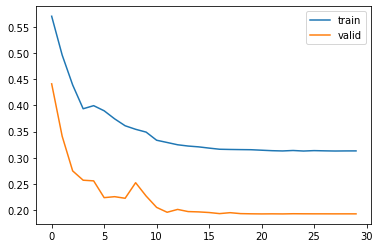

In [ ]:
infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
plt.legend()
plt.show()

In [ ]:
preds, attn_weights = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])

test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
test_label = test_label[target[0]] # target[0] : HeartDisease 

attn_weights = torch.cat(attn_weights, dim=0)

TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)

  0%|          | 0/7 [00:00<?, ?it/s]

0.77

## 2-4. ATTENTION PLOT

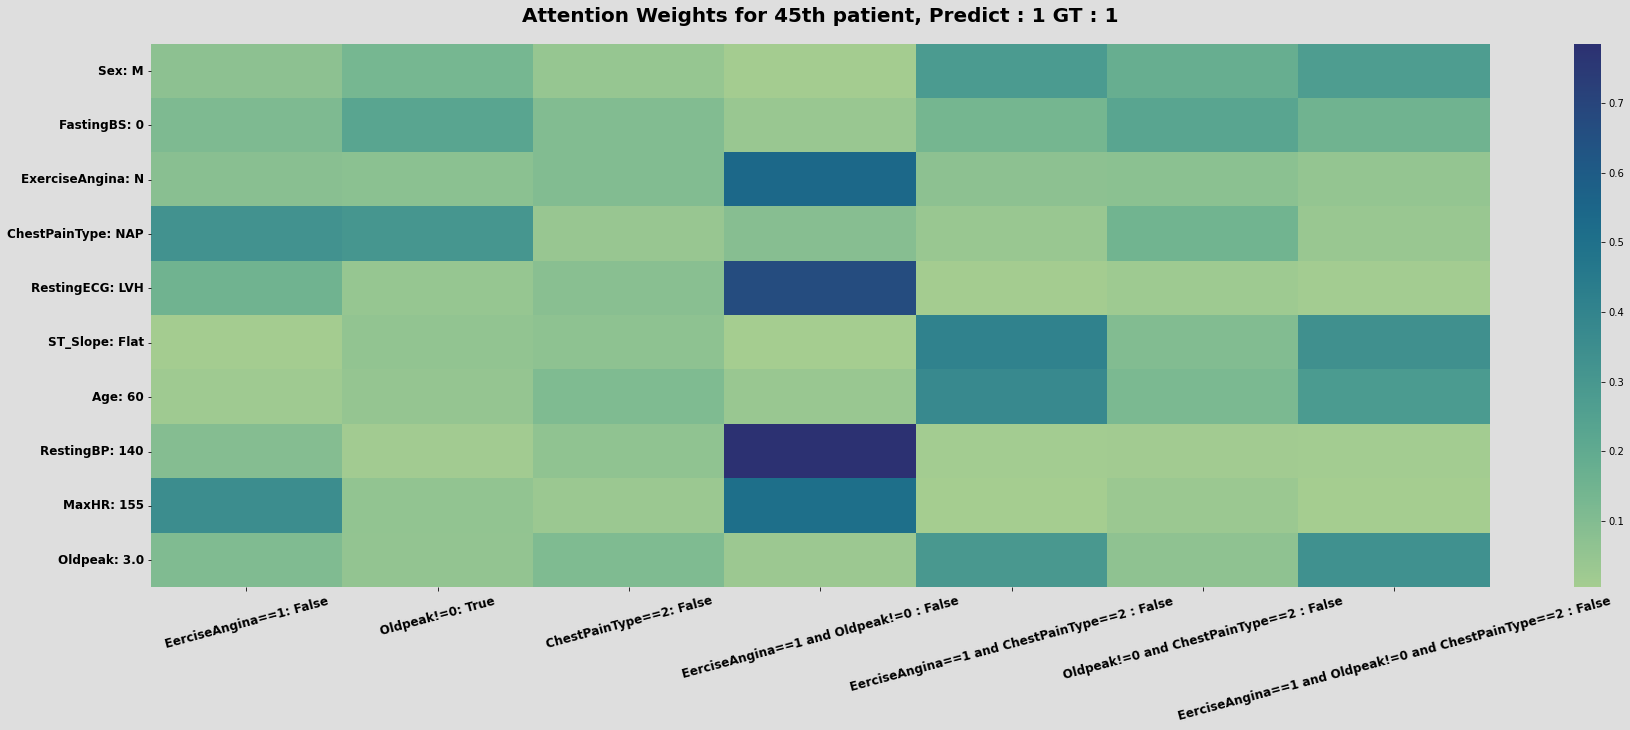

In [ ]:
# attention plot in test
import seaborn as sns
temp_test = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')

def getAttentionPlot(idx):
    corr = pd.DataFrame(data=attn_weights[idx].to('cpu').numpy())

    _, _, b_feature = test_dataset.__getitem__(idx)
    b_feature = b_feature.numpy()

    xticks = [bc[11:] for bc in bicons_string.split('\n')[3:-2]]
    xticks = [bc.replace('x','') for bc in xticks]
    xticks = [bc.replace('[','') for bc in xticks]
    xticks = [bc.replace(']','') for bc in xticks]
    xticks = [bc.replace(' ','') for bc in xticks]
    xticks = [bc.replace(',','') for bc in xticks]
    xticks = [bc.replace('\'','') for bc in xticks]
    xticks = [bc.replace(')',' ') for bc in xticks]
    xticks = [bc.replace('(',' ') for bc in xticks]
    xticks = [f'{xticks[i]}: {str(bool(b_feature[i]))}' for i in range(len(b_feature))]

    t_feature = temp_test[cat_features + num_features].iloc[idx]
    yticks = [f'{t_feature.index[i]}: {t_feature[i]}' for i in range(len(t_feature))]

    fig, ax = plt.subplots(1,1, figsize=(30, 10), sharey=True)
    fig.patch.set_facecolor('#dedede')
    sns.heatmap(corr, cmap='crest', cbar=True, ax=ax)
    ax.text(0.5, 1.05, f'Attention Weights for {idx}th patient, Predict : {int(preds[idx])} GT : {int(temp_test["HeartDisease"].iloc[idx])}',
            horizontalalignment='center', verticalalignment='center',
            fontsize=20, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels(xticks, rotation=15, fontsize=12, fontweight='bold')
    ax.set_yticklabels(yticks, rotation=0, fontsize=12, fontweight='bold')

getAttentionPlot(45)

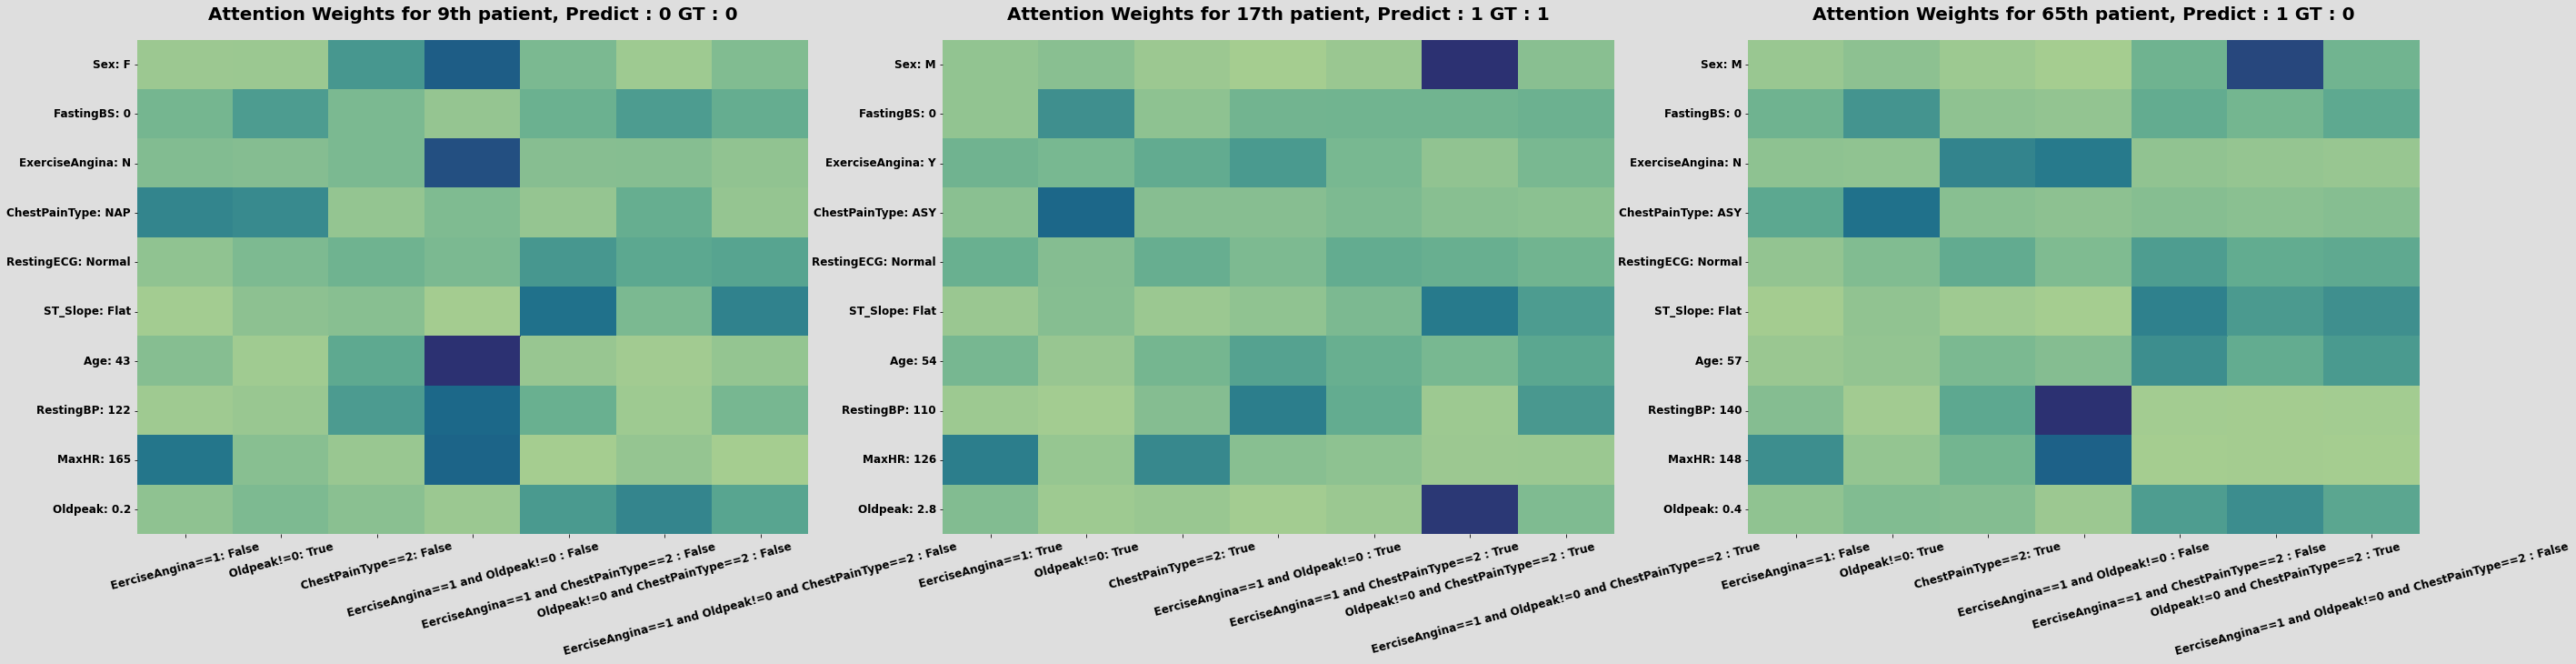

In [ ]:
# attention plot in test
import seaborn as sns
temp_test = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')

def getAttentionPlot3(indices):
    fig, axes = plt.subplots(1,len(indices), figsize=(45, 10), sharey=False)
    fig.patch.set_facecolor('#dedede')
    for i, idx in enumerate(indices):
        corr = pd.DataFrame(data=attn_weights[idx].to('cpu').numpy())

        _, _, b_feature = test_dataset.__getitem__(idx)
        b_feature = b_feature.numpy()

        xticks = [bc[11:] for bc in bicons_string.split('\n')[3:-2]]
        xticks = [bc.replace('x','') for bc in xticks]
        xticks = [bc.replace('[','') for bc in xticks]
        xticks = [bc.replace(']','') for bc in xticks]
        xticks = [bc.replace(' ','') for bc in xticks]
        xticks = [bc.replace(',','') for bc in xticks]
        xticks = [bc.replace('\'','') for bc in xticks]
        xticks = [bc.replace(')',' ') for bc in xticks]
        xticks = [bc.replace('(',' ') for bc in xticks]
        xticks = [f'{xticks[i]}: {str(bool(b_feature[i]))}' for i in range(len(b_feature))]

        t_feature = temp_test[cat_features + num_features].iloc[idx]
        yticks = [f'{t_feature.index[i]}: {t_feature[i]}' for i in range(len(t_feature))]

        # cbar = True if i is len(indices)-1 else False
        sns.heatmap(corr, cmap='crest', cbar=False, ax=axes[i])
        axes[i].text(0.5, 1.05, f'Attention Weights for {idx}th patient, Predict : {int(preds[idx])} GT : {int(temp_test["HeartDisease"].iloc[idx])}',
                horizontalalignment='center', verticalalignment='center',
                fontsize=20, fontweight='bold', transform=axes[i].transAxes)
        axes[i].set_xticklabels(xticks, rotation=15, fontsize=12, fontweight='bold')
        axes[i].set_yticklabels(yticks, rotation=0, fontsize=12, fontweight='bold')

getAttentionPlot3([9,17,65])

## 2-5. EXPERIMENT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    # 'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        'SCORE' : metrics.accuracy_score
        # 'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
test_scores = []
EXPERIMENT_NUM = 30

for _ in range(EXPERIMENT_NUM):
    # Load df
    train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


    num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
    cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
    target = ['HeartDisease', 'Cholesterol']

    # Label Encoding
    categories = []
    for feature in cat_features:
        train_df[feature], class_map = class_mapping(train_df, feature)
        test_df[feature] = test_df[feature].map(class_map)

        # categories class num
        categories.append(len(class_map))
    categories = tuple(categories)


    # train_valid split
    train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                    train_df[[target[0]]], # target[0] : HeartDisease 
                                                                    test_size=100, 
                                                                    )
    test_df = test_df[num_features + cat_features]


    # Standard Scaling
    sc_df = StandardScaler()

    sc_df.fit(train_df[num_features])

    train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
    valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
    test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])


    # DataSet
    train_dataset = CustomDataset(train_df, train_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

    valid_dataset = CustomDataset(valid_df, valid_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_df, None, bicons=bicons, cat_features=cat_features, num_features=num_features)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


    # model, optimizer, scheduler
    model = BiconFTTransformer(categories = categories,
                            num_continuous = len(num_features),
                            num_bicons = len(bicons), # Number of Binary Conditions (Input)
                            embed_dim = 8,
                            depth = 1,
                            heads = 2,
                            dim_out = 1,
                            num_special_tokens = 2,
                            attn_dropout = 0.,
                            ff_dropout = 0.,
                            )          

    model.eval()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])


    # Infer model
    infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

    plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
    plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
    plt.legend()
    plt.show()


    # Test Scoring
    preds, _ = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])

    test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
    test_label = test_label[target[0]] # target[0] : HeartDisease 

    test_score = TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)
    test_scores.append([test_score])

In [ ]:
test_scores = np.array(test_scores)
np.mean(test_scores), np.std(test_scores)

# 3. Cholesterol_FTTransformer_Experiment

## 3-1. DATASET

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, labels=None, cat_features=None, num_features=None):
        self.cat_df = df[cat_features]
        self.num_df = df[num_features]
        self.labels = labels


    def __getitem__(self, index):
                
        if self.labels is not None:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            label = torch.Tensor(self.labels.iloc[index])
            return x_categ, x_numer, label
        else:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            return x_categ, x_numer
        
    def __len__(self):
        return len(self.cat_df)

## 3-2. TRAIN VALID FUNCTION

In [ ]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, cfg):
    model.to(device)
    criterion = cfg['CRITERION']
    
    best_score = 1000
    best_model = None
    
    train_losses = []
    val_losses = []

    for epoch in range(1, cfg['EPOCHS']+1):
        model.train()
        train_loss = []
        for x_categ, x_numer, label in tqdm(iter(train_loader)):

            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred = model(x_categ, x_numer)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device, cfg['VALIDATION_CFG'])
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_losses.append(np.mean(train_loss))
        val_losses.append(val_loss)


        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score > val_score:
            best_score = val_score
            best_model = model
    
    return best_model, train_losses, val_losses

In [ ]:
def validation(model, criterion, val_loader, device, cfg):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = cfg['THRESHOLD']
    with torch.no_grad():
        for x_categ, x_numer, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            label = label.float().to(device)
            
            model_pred = model(x_categ, x_numer)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    # pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    pred_labels = np.array(pred_labels)
    val_score = cfg['SCORE'](y_true=true_labels, y_pred=pred_labels)
    return np.mean(val_loss), val_score

In [ ]:
def inference(model, test_loader, device, cfg):
    model.to(device)
    model.eval()
    preds = []
    threshold = cfg['THRESHOLD']
    
    with torch.no_grad():
        for x_categ, x_numer in tqdm(iter(test_loader)):
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)

            model_pred = model(x_categ, x_numer)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    # preds = np.where(np.array(preds) > threshold, 1, 0)
    preds = np.array(preds)
    
    return preds

## 3-3. CHECK MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    # 'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        # 'SCORE' : metrics.accuracy_score
        'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
def class_mapping(df, feature):
    class_map = {cls:val for val,cls in enumerate(df[feature].unique())}
    print(f'{feature} => {class_map}')
    return df[feature].map(class_map), class_map


train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
target = ['HeartDisease', 'Cholesterol']


categories = []
for feature in cat_features:
    train_df[feature], class_map = class_mapping(train_df, feature)
    test_df[feature] = test_df[feature].map(class_map)

    # categories class num
    categories.append(len(class_map))
categories = tuple(categories)


# Drop Cholesterol
mask = train_df['Cholesterol'] == 0
train_df = train_df[~mask]


train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                  train_df[[target[1]]], # target[0] : HeartDisease 
                                                                  test_size=100, 
                                                                  )
test_df = test_df[num_features + cat_features]

Sex => {'M': 0, 'F': 1}
FastingBS => {0: 0, 1: 1}
ExerciseAngina => {'N': 0, 'Y': 1}
ChestPainType => {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
RestingECG => {'Normal': 0, 'ST': 1, 'LVH': 2}
ST_Slope => {'Up': 0, 'Flat': 1, 'Down': 2}


In [ ]:
sc_df = StandardScaler()
sc_labels = StandardScaler()

sc_df.fit(train_df[num_features])
sc_labels.fit(train_labels)

train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

train_labels.loc[:] = sc_labels.transform(train_labels)
valid_labels.loc[:] = sc_labels.transform(valid_labels)

In [ ]:
train_dataset = CustomDataset(train_df, train_labels, cat_features=cat_features, num_features=num_features)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_dataset = CustomDataset(valid_df, valid_labels, cat_features=cat_features, num_features=num_features)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_df, None, cat_features=cat_features, num_features=num_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
model = FTTransformer(categories = categories,
                           num_continuous = len(num_features),
                           embed_dim = 8,
                           depth = 1,
                           heads = 2,
                           dim_out = 1,
                           num_special_tokens = 2,
                           attn_dropout = 0.,
                           ff_dropout = 0.,
                          )          

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.77919] Val Loss : [0.85946] Val Score : [0.85179]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.74322] Val Loss : [0.83745] Val Score : [0.82921]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.73551] Val Loss : [0.83288] Val Score : [0.82504]
Epoch 00003: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.71955] Val Loss : [0.83244] Val Score : [0.82598]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.73789] Val Loss : [0.83165] Val Score : [0.82739]
Epoch 00005: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.72600] Val Loss : [0.82813] Val Score : [0.82501]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.71918] Val Loss : [0.82647] Val Score : [0.82431]
Epoch 00007: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.70713] Val Loss : [0.82595] Val Score : [0.82377]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.76139] Val Loss : [0.82539] Val Score : [0.82318]
Epoch 00009: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.71297] Val Loss : [0.82632] Val Score : [0.82335]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.72068] Val Loss : [0.82518] Val Score : [0.82219]
Epoch 00011: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.69970] Val Loss : [0.82430] Val Score : [0.82130]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.71337] Val Loss : [0.82424] Val Score : [0.82115]
Epoch 00013: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.71881] Val Loss : [0.82461] Val Score : [0.82158]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.69282] Val Loss : [0.82437] Val Score : [0.82123]
Epoch 00015: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.69705] Val Loss : [0.82417] Val Score : [0.82104]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.71788] Val Loss : [0.82419] Val Score : [0.82108]
Epoch 00017: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.69735] Val Loss : [0.82418] Val Score : [0.82108]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.71233] Val Loss : [0.82407] Val Score : [0.82096]
Epoch 00019: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.70554] Val Loss : [0.82405] Val Score : [0.82095]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.70729] Val Loss : [0.82402] Val Score : [0.82092]
Epoch 00021: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.69226] Val Loss : [0.82403] Val Score : [0.82093]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.70584] Val Loss : [0.82399] Val Score : [0.82090]
Epoch 00023: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.71005] Val Loss : [0.82399] Val Score : [0.82090]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.71515] Val Loss : [0.82399] Val Score : [0.82089]
Epoch 00025: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.70644] Val Loss : [0.82398] Val Score : [0.82089]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.71826] Val Loss : [0.82398] Val Score : [0.82088]
Epoch 00027: reducing learning rate of group 0 to 6.1035e-07.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.71645] Val Loss : [0.82398] Val Score : [0.82088]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.69798] Val Loss : [0.82398] Val Score : [0.82088]
Epoch 00029: reducing learning rate of group 0 to 3.0518e-07.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.70916] Val Loss : [0.82397] Val Score : [0.82088]


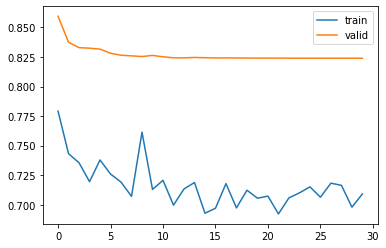

In [ ]:
infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
plt.legend()
plt.show()

In [ ]:
preds = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])
preds = sc_labels.inverse_transform(preds.reshape(-1,1))

test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
test_label = test_label[target[1]]

TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)

  0%|          | 0/7 [00:00<?, ?it/s]

40.03359340057134

## 3-4. EXPERIMENT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    # 'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        # 'SCORE' : accuracy_score
        'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
test_scores = []
EXPERIMENT_NUM = 30

for _ in range(EXPERIMENT_NUM):
    # Load df
    train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


    num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
    cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
    target = ['HeartDisease', 'Cholesterol']

    # Label Encoding
    categories = []
    for feature in cat_features:
        train_df[feature], class_map = class_mapping(train_df, feature)
        test_df[feature] = test_df[feature].map(class_map)

        # categories class num
        categories.append(len(class_map))
    categories = tuple(categories)


    # Drop Cholesterol
    mask = train_df['Cholesterol'] == 0
    train_df = train_df[~mask]


    # train_valid split
    train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                    train_df[[target[1]]], # target[0] : HeartDisease 
                                                                    test_size=100, 
                                                                    )
    test_df = test_df[num_features + cat_features]


    # Standard Scaling
    sc_df = StandardScaler()
    sc_labels = StandardScaler()

    sc_df.fit(train_df[num_features])
    sc_labels.fit(train_labels)

    train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
    valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
    test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

    train_labels.loc[:] = sc_labels.transform(train_labels)
    valid_labels.loc[:] = sc_labels.transform(valid_labels)


    # DataSet
    train_dataset = CustomDataset(train_df, train_labels, cat_features=cat_features, num_features=num_features)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

    valid_dataset = CustomDataset(valid_df, valid_labels, cat_features=cat_features, num_features=num_features)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_df, None, cat_features=cat_features, num_features=num_features)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


    # model, optimizer, scheduler
    model = FTTransformer(categories = categories,
                            num_continuous = len(num_features),
                            embed_dim = 8,
                            depth = 1,
                            heads = 2,
                            dim_out = 1,
                            num_special_tokens = 2,
                            attn_dropout = 0.,
                            ff_dropout = 0.,
                            )          

    model.eval()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])


    # Infer model
    infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

    plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
    plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
    plt.legend()
    plt.show()


    # Test Scoring
    preds = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])
    preds = sc_labels.inverse_transform(preds.reshape(-1,1))

    test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
    test_label = test_label[target[1]]

    test_score = TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)
    test_scores.append([test_score])

In [ ]:
test_scores = np.array(test_scores)
np.mean(test_scores), np.std(test_scores)

# 4. Cholesterol_BiconFTTransformer_Attention_Plot_Experiment

## 4-1. DATASET

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, labels=None, bicons=None, cat_features=None, num_features=None):
        self.cat_df = df[cat_features]
        self.num_df = df[num_features]
        self.labels = labels
        
        bicon_df = []
        for bicon in bicons:
            bicon_df.append(df.apply(bicon, axis=1))
        self.bicon_df = pd.concat(bicon_df, axis=1)


    def __getitem__(self, index):
                
        if self.labels is not None:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            x_bicon = torch.Tensor(self.bicon_df.iloc[index])
            label = torch.Tensor(self.labels.iloc[index])
            return x_categ, x_numer, x_bicon, label
        else:
            x_categ = torch.Tensor(self.cat_df.iloc[index])
            x_numer = torch.Tensor(self.num_df.iloc[index])
            x_bicon = torch.Tensor(self.bicon_df.iloc[index])
            return x_categ, x_numer, x_bicon
        
    def __len__(self):
        return len(self.cat_df)

## 4-2. TRAIN VALID FUNCTION

In [ ]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, cfg):
    model.to(device)
    criterion = cfg['CRITERION']
    
    best_score = 1000
    best_model = None
    
    train_losses = []
    val_losses = []

    for epoch in range(1, cfg['EPOCHS']+1):
        model.train()
        train_loss = []
        for x_categ, x_numer, x_bicon, label in tqdm(iter(train_loader)):

            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)
            label = label.float().to(device)
            
            optimizer.zero_grad()
            
            model_pred, _ = model(x_categ, x_numer, x_bicon)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_score = validation(model, criterion, val_loader, device, cfg['VALIDATION_CFG'])
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        train_losses.append(np.mean(train_loss))
        val_losses.append(val_loss)


        if scheduler is not None:
            scheduler.step(val_score)
        
        if best_score > val_score:
            best_score = val_score
            best_model = model
    
    return best_model, train_losses, val_losses

In [ ]:
def validation(model, criterion, val_loader, device, cfg):
    model.eval()
    pred_labels = []
    true_labels = []
    val_loss = []
    threshold = cfg['THRESHOLD']
    with torch.no_grad():
        for x_categ, x_numer, x_bicon, label in tqdm(iter(val_loader)):
            true_labels += label.tolist()
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)
            label = label.float().to(device)
            
            model_pred, _ = model(x_categ, x_numer, x_bicon)
            
            loss = criterion(model_pred, label.reshape(-1,1))
            
            val_loss.append(loss.item())
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
    
    # pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
    pred_labels = np.array(pred_labels)
    val_score = cfg['SCORE'](y_true=true_labels, y_pred=pred_labels)
    return np.mean(val_loss), val_score

In [ ]:
def inference(model, test_loader, device, cfg):
    model.to(device)
    model.eval()
    preds = []
    attn_weights_list = []
    threshold = cfg['THRESHOLD']
    
    with torch.no_grad():
        for x_categ, x_numer, x_bicon in tqdm(iter(test_loader)):
            
            x_categ = x_categ.int().to(device)
            x_numer = x_numer.float().to(device)
            x_bicon = x_bicon.int().to(device)

            model_pred, attn_weights = model(x_categ, x_numer, x_bicon)
            attn_weights_list.append(attn_weights)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            
            preds += model_pred.tolist()
    
    # preds = np.where(np.array(preds) > threshold, 1, 0)
    preds = np.array(preds)
    
    return preds, attn_weights_list

## 4-3. CHECK MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    # 'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        # 'SCORE' : metrics.accuracy_score
        'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
def class_mapping(df, feature):
    class_map = {cls:val for val,cls in enumerate(df[feature].unique())}
    print(f'{feature} => {class_map}')
    return df[feature].map(class_map), class_map


train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
target = ['HeartDisease', 'Cholesterol']


categories = []
for feature in cat_features:
    train_df[feature], class_map = class_mapping(train_df, feature)
    test_df[feature] = test_df[feature].map(class_map)

    # categories class num
    categories.append(len(class_map))
categories = tuple(categories)


# Drop Cholesterol
mask = train_df['Cholesterol'] == 0
train_df = train_df[~mask]


train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                  train_df[[target[1]]], # target[0] : HeartDisease 
                                                                  test_size=100, 
                                                                  )
test_df = test_df[num_features + cat_features]

Sex => {'M': 0, 'F': 1}
FastingBS => {0: 0, 1: 1}
ExerciseAngina => {'N': 0, 'Y': 1}
ChestPainType => {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
RestingECG => {'Normal': 0, 'ST': 1, 'LVH': 2}
ST_Slope => {'Up': 0, 'Flat': 1, 'Down': 2}


In [ ]:
sc_df = StandardScaler()
sc_labels = StandardScaler()

sc_df.fit(train_df[num_features])
sc_labels.fit(train_labels)

train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

train_labels.loc[:] = sc_labels.transform(train_labels)
valid_labels.loc[:] = sc_labels.transform(valid_labels)

In [ ]:
bicons_string = '''
bicons = [

lambda x: x['Sex'] == 0,
lambda x: x['FastingBS'] == 0,
lambda x: x['Sex'] == 0 and x['FastingBS'] == 0,
]
'''
exec(bicons_string)
bicons = bicons

In [ ]:
train_dataset = CustomDataset(train_df, train_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_dataset = CustomDataset(valid_df, valid_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_df, None, bicons=bicons, cat_features=cat_features, num_features=num_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
model = BiconFTTransformer(categories = categories,
                           num_continuous = len(num_features),
                           num_bicons = len(bicons), # Number of Binary Conditions (Input)
                           embed_dim = 8,
                           depth = 1,
                           heads = 2,
                           dim_out = 1,
                           num_special_tokens = 2,
                           attn_dropout = 0.,
                           ff_dropout = 0.,
                          )          

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.75083] Val Loss : [0.94300] Val Score : [0.92987]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.75130] Val Loss : [0.95858] Val Score : [0.94276]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.73708] Val Loss : [0.92697] Val Score : [0.91555]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.73216] Val Loss : [0.94096] Val Score : [0.92879]
Epoch 00004: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.72654] Val Loss : [0.92859] Val Score : [0.91835]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.74146] Val Loss : [0.92859] Val Score : [0.91888]
Epoch 00006: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.71945] Val Loss : [0.93027] Val Score : [0.92108]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.73028] Val Loss : [0.93260] Val Score : [0.92323]
Epoch 00008: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.72747] Val Loss : [0.93117] Val Score : [0.92246]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.71869] Val Loss : [0.93059] Val Score : [0.92232]
Epoch 00010: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.72441] Val Loss : [0.93248] Val Score : [0.92400]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.72056] Val Loss : [0.92774] Val Score : [0.92054]
Epoch 00012: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.72788] Val Loss : [0.92930] Val Score : [0.92185]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.71851] Val Loss : [0.92911] Val Score : [0.92175]
Epoch 00014: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.71725] Val Loss : [0.92893] Val Score : [0.92164]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.72588] Val Loss : [0.92948] Val Score : [0.92209]
Epoch 00016: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.73155] Val Loss : [0.92960] Val Score : [0.92219]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.73469] Val Loss : [0.92950] Val Score : [0.92215]
Epoch 00018: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.73244] Val Loss : [0.92953] Val Score : [0.92219]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.72463] Val Loss : [0.92944] Val Score : [0.92213]
Epoch 00020: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.72980] Val Loss : [0.92939] Val Score : [0.92210]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.72430] Val Loss : [0.92932] Val Score : [0.92206]
Epoch 00022: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.71879] Val Loss : [0.92928] Val Score : [0.92202]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.75852] Val Loss : [0.92926] Val Score : [0.92201]
Epoch 00024: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.72325] Val Loss : [0.92924] Val Score : [0.92200]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.71486] Val Loss : [0.92923] Val Score : [0.92199]
Epoch 00026: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.73135] Val Loss : [0.92924] Val Score : [0.92200]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.72742] Val Loss : [0.92925] Val Score : [0.92201]
Epoch 00028: reducing learning rate of group 0 to 6.1035e-07.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.73081] Val Loss : [0.92925] Val Score : [0.92200]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.71419] Val Loss : [0.92925] Val Score : [0.92201]
Epoch 00030: reducing learning rate of group 0 to 3.0518e-07.


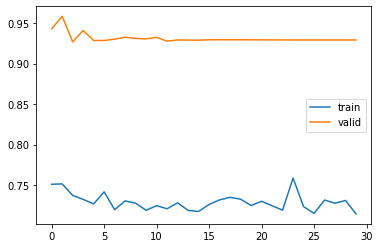

In [ ]:
infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
plt.legend()
plt.show()

In [ ]:
preds, attn_weights = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])
preds = sc_labels.inverse_transform(preds.reshape(-1,1))

test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
test_label = test_label[target[1]]

attn_weights = torch.cat(attn_weights, dim=0)

TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)

  0%|          | 0/7 [00:00<?, ?it/s]

40.23209611944785

## 4-4. ATTENTION PLOT

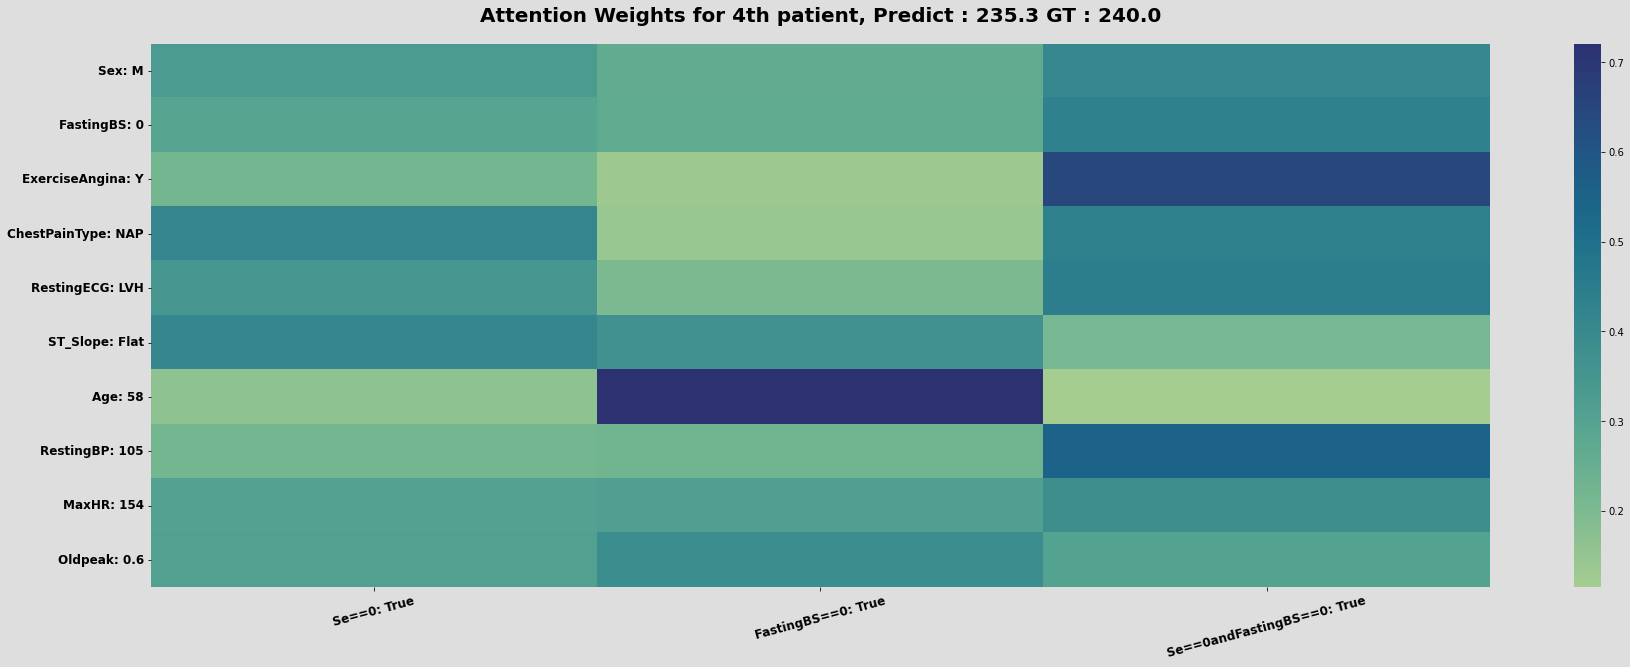

In [ ]:
# attention plot in test
import seaborn as sns
temp_test = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')

def getAttentionPlot(idx):
    corr = pd.DataFrame(data=attn_weights[idx].to('cpu').numpy())

    _, _, b_feature = test_dataset.__getitem__(idx)
    b_feature = b_feature.numpy()

    xticks = [bc[11:] for bc in bicons_string.split('\n')[3:-2]]
    xticks = [bc.replace('x','') for bc in xticks]
    xticks = [bc.replace('[','') for bc in xticks]
    xticks = [bc.replace(']','') for bc in xticks]
    xticks = [bc.replace(' ','') for bc in xticks]
    xticks = [bc.replace(',','') for bc in xticks]
    xticks = [bc.replace('\'','') for bc in xticks]
    xticks = [bc.replace(')',' ') for bc in xticks]
    xticks = [bc.replace('(',' ') for bc in xticks]
    xticks = [f'{xticks[i]}: {str(bool(b_feature[i]))}' for i in range(len(b_feature))]

    t_feature = temp_test[cat_features + num_features].iloc[idx]
    yticks = [f'{t_feature.index[i]}: {t_feature[i]}' for i in range(len(t_feature))]

    fig, ax = plt.subplots(1,1, figsize=(30, 10), sharey=True)
    fig.patch.set_facecolor('#dedede')
    sns.heatmap(corr, cmap='crest', cbar=True, ax=ax)
    ax.text(0.5, 1.05, f'Attention Weights for {idx}th patient, Predict : {preds[idx][0]:.1f} GT : {temp_test["Cholesterol"].iloc[idx]:.1f}',
            horizontalalignment='center', verticalalignment='center',
            fontsize=20, fontweight='bold', transform=ax.transAxes)
    ax.set_xticklabels(xticks, rotation=15, fontsize=12, fontweight='bold')
    ax.set_yticklabels(yticks, rotation=0, fontsize=12, fontweight='bold')

getAttentionPlot(4)

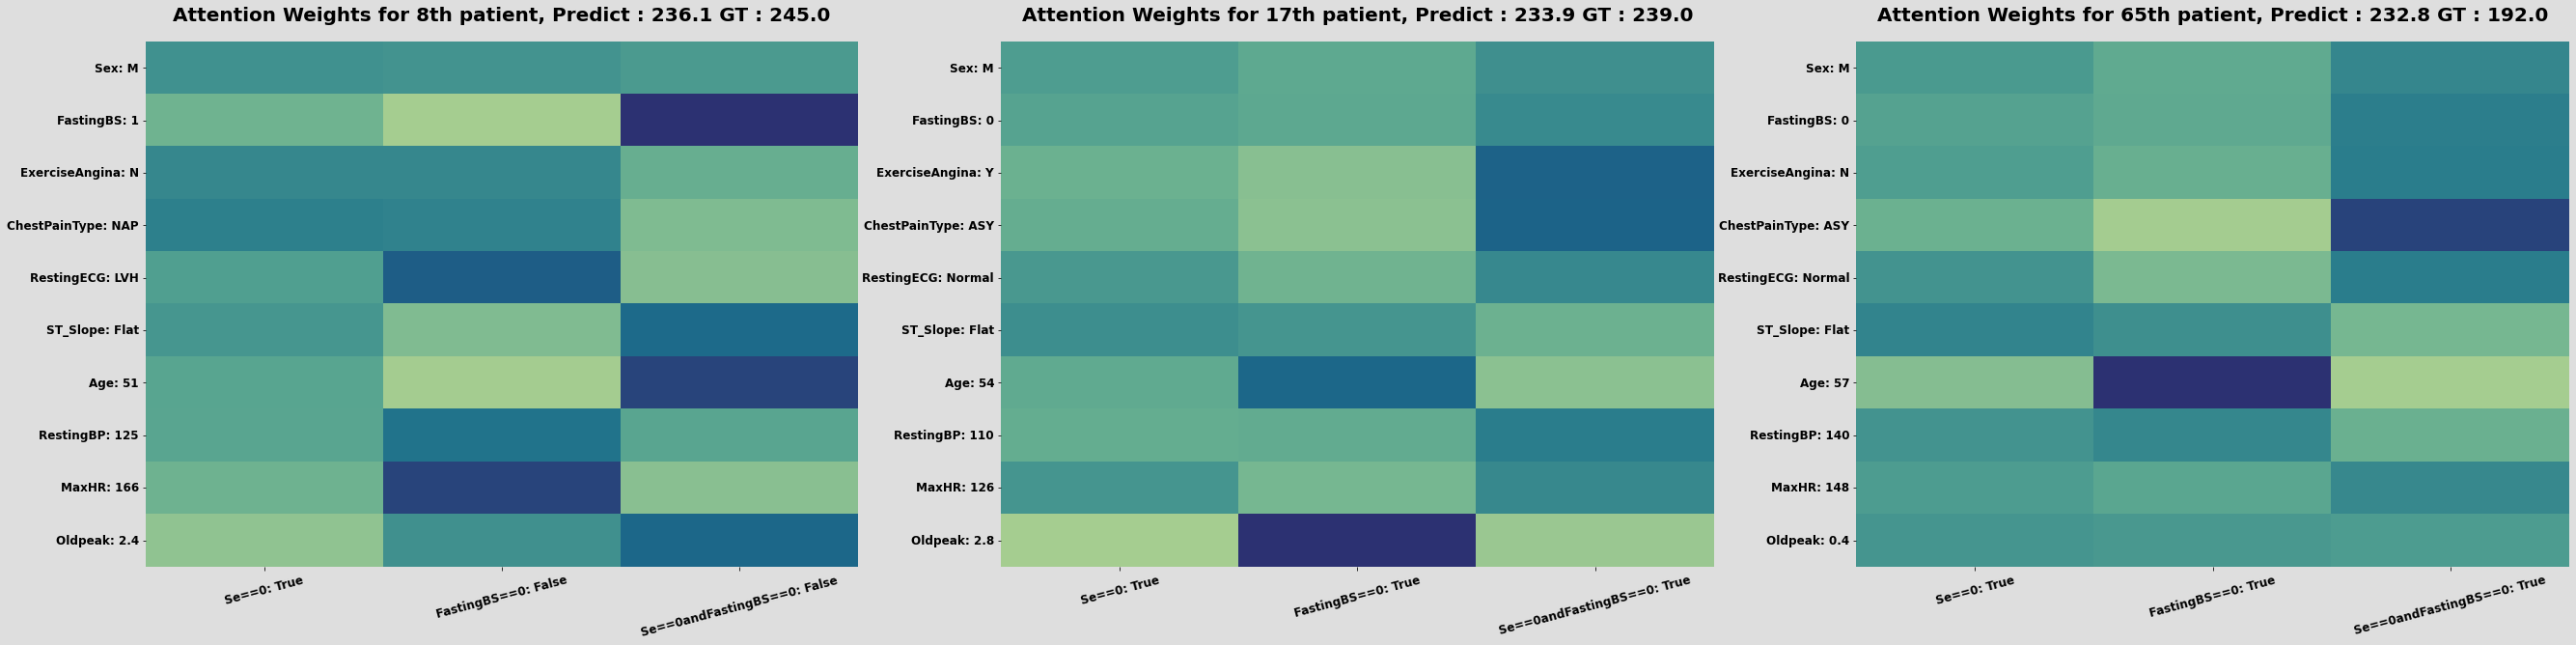

In [ ]:
# attention plot in test
import seaborn as sns
temp_test = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')

def getAttentionPlot3(indices):
    fig, axes = plt.subplots(1,len(indices), figsize=(45, 10), sharey=False)
    fig.patch.set_facecolor('#dedede')
    for i, idx in enumerate(indices):
        corr = pd.DataFrame(data=attn_weights[idx].to('cpu').numpy())

        _, _, b_feature = test_dataset.__getitem__(idx)
        b_feature = b_feature.numpy()

        xticks = [bc[11:] for bc in bicons_string.split('\n')[3:-2]]
        xticks = [bc.replace('x','') for bc in xticks]
        xticks = [bc.replace('[','') for bc in xticks]
        xticks = [bc.replace(']','') for bc in xticks]
        xticks = [bc.replace(' ','') for bc in xticks]
        xticks = [bc.replace(',','') for bc in xticks]
        xticks = [bc.replace('\'','') for bc in xticks]
        xticks = [bc.replace(')',' ') for bc in xticks]
        xticks = [bc.replace('(',' ') for bc in xticks]
        xticks = [f'{xticks[i]}: {str(bool(b_feature[i]))}' for i in range(len(b_feature))]

        t_feature = temp_test[cat_features + num_features].iloc[idx]
        yticks = [f'{t_feature.index[i]}: {t_feature[i]}' for i in range(len(t_feature))]

        # cbar = True if i is len(indices)-1 else False
        sns.heatmap(corr, cmap='crest', cbar=False, ax=axes[i])
        axes[i].text(0.5, 1.05, f'Attention Weights for {idx}th patient, Predict : {preds[idx][0]:.1f} GT : {temp_test["Cholesterol"].iloc[idx]:.1f}',
                horizontalalignment='center', verticalalignment='center',
                fontsize=20, fontweight='bold', transform=axes[i].transAxes)
        axes[i].set_xticklabels(xticks, rotation=15, fontsize=12, fontweight='bold')
        axes[i].set_yticklabels(yticks, rotation=0, fontsize=12, fontweight='bold')

getAttentionPlot3([8,17,65])

## 4-5. EXPERIMENT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAINING_CFG = {
    'EPOCHS' : 30,
    'LEARNING_RATE' : 5e-3,
    # 'CRITERION' : nn.BCEWithLogitsLoss().to(device),
    'CRITERION' : nn.L1Loss().to(device),
    # 'CRITERION' : nn.MSELoss().to(device),
    # 'CRITERION' : nn.SmoothL1Loss().to(device),

    'SCHEDULER' : {
        'mode':'max',
        'factor':0.5,
        'patience':1,
        'threshold_mode':'abs',
        'min_lr':1e-8,
        'verbose':True,
    },
    
    'VALIDATION_CFG' : {
        'THRESHOLD' : 0.5,
        # 'SCORE' : accuracy_score
        'SCORE' : metrics.mean_absolute_error
    },
}

In [ ]:
test_scores = []
EXPERIMENT_NUM = 30

for _ in range(EXPERIMENT_NUM):
    # Load df
    train_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/train/train.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_without_labels/test_without_labels.csv')


    num_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
    cat_features = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
    target = ['HeartDisease', 'Cholesterol']

    # Label Encoding
    categories = []
    for feature in cat_features:
        train_df[feature], class_map = class_mapping(train_df, feature)
        test_df[feature] = test_df[feature].map(class_map)

        # categories class num
        categories.append(len(class_map))
    categories = tuple(categories)


    # Drop Cholesterol
    mask = train_df['Cholesterol'] == 0
    train_df = train_df[~mask]


    # train_valid split
    train_df, valid_df, train_labels, valid_labels = train_test_split(train_df[num_features + cat_features], 
                                                                    train_df[[target[1]]], # target[0] : HeartDisease 
                                                                    test_size=100, 
                                                                    )
    test_df = test_df[num_features + cat_features]


    # Standard Scaling
    sc_df = StandardScaler()
    sc_labels = StandardScaler()

    sc_df.fit(train_df[num_features])
    sc_labels.fit(train_labels)

    train_df.loc[:,num_features] = sc_df.transform(train_df[num_features])
    valid_df.loc[:,num_features] = sc_df.transform(valid_df[num_features])
    test_df.loc[:,num_features] = sc_df.transform(test_df[num_features])

    train_labels.loc[:] = sc_labels.transform(train_labels)
    valid_labels.loc[:] = sc_labels.transform(valid_labels)


    # DataSet
    train_dataset = CustomDataset(train_df, train_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

    valid_dataset = CustomDataset(valid_df, valid_labels, bicons=bicons, cat_features=cat_features, num_features=num_features)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

    test_dataset = CustomDataset(test_df, None, bicons=bicons, cat_features=cat_features, num_features=num_features)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


    # model, optimizer, scheduler
    model = BiconFTTransformer(categories = categories,
                            num_continuous = len(num_features),
                            num_bicons = len(bicons), # Number of Binary Conditions (Input)
                            embed_dim = 8,
                            depth = 1,
                            heads = 2,
                            dim_out = 1,
                            num_special_tokens = 2,
                            attn_dropout = 0.,
                            ff_dropout = 0.,
                            )          

    model.eval()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = TRAINING_CFG['LEARNING_RATE'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **TRAINING_CFG['SCHEDULER'])


    # Infer model
    infer_model, train_losses, valid_losses = train(model, optimizer, train_loader, valid_loader, device, scheduler, TRAINING_CFG)

    plt.plot(range(TRAINING_CFG['EPOCHS']), train_losses, label='train')
    plt.plot(range(TRAINING_CFG['EPOCHS']), valid_losses, label='valid')
    plt.legend()
    plt.show()


    # Test Scoring
    preds, _ = inference(infer_model, test_loader, device, TRAINING_CFG['VALIDATION_CFG'])
    preds = sc_labels.inverse_transform(preds.reshape(-1,1))

    test_label = pd.read_csv('/content/drive/MyDrive/DataScience_Midterm_Project/test_with_labels/test_with_labels.csv')
    test_label = test_label[target[1]]

    test_score = TRAINING_CFG['VALIDATION_CFG']['SCORE'](test_label, preds)
    test_scores.append([test_score])

In [ ]:
test_scores = np.array(test_scores)
np.mean(test_scores), np.std(test_scores)